In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import numpy as np

In [2]:
def date_to_datetime(data):
    data.time = pd.to_datetime(data.time, infer_datetime_format=True)

    data = data.set_index('time', drop=True)  

    return data    

In [3]:
def plot_data(data, column):
    plt.rcParams['figure.figsize'] = (16, 4)
    data[[column]].plot()
    plt.xlabel('Time')
    plt.title('Price of electricity')
    plt.show()

In [4]:
def plot_multiple_datasets(datasets, column):
    #plt.rcParams['figure.figsize'] = (16, 4)
    for dataset in datasets:
        dataset_ = dataset.copy()
        beginning = dataset_.index[0].date()
        end = dataset_.index[-1].date()
        dataset_.index = dataset_.index.strftime('%m-%d %H:%M:%S')
        dataset_[column].plot(label=f"{str(beginning)} - {str(end)}")
    #plt.xlabel('Time')
    plt.title(column)
    plt.legend()
    plt.show()



In [5]:
def predict_from_past(data, beginning_date, end_date):
    mean_previous_years = (data[(data.index>=f"2015-{beginning_date.month}-{beginning_date.day}")&(data.index<f"2015-{end_date.month}-{end_date.day+1}")].reset_index()["price"]+data[(data.index>=f"2016-{beginning_date.month}-{beginning_date.day}")&(data.index<f"2016-{end_date.month}-{end_date.day+1}")].reset_index()["price"])/2
    actual_data = data[(data.index>=f"2017-{beginning_date.month}-{beginning_date.day}")&(data.index<f"2017-{end_date.month}-{end_date.day+1}")]
    mae = mean_absolute_error(actual_data.price.values, mean_previous_years)
    return mean_previous_years, actual_data, mae

In [6]:
def slice_dates(data, beginning_date, end_date):
    return data[(data.index>=beginning_date)&(data.index<=end_date)]


In [15]:
data_v1 = pd.read_csv("data/data_v1.csv")
data_v2 = pd.read_csv("data/data_v2.csv")

data_v1 = date_to_datetime(data_v1)
data_v2 = date_to_datetime(data_v2)


In [13]:
data_v1.dropna().tail()

,time,price,exog
667,2017-12-24 19:00:00,77.99,2446.0
668,2017-12-24 20:00:00,78.69,2483.0
669,2017-12-24 21:00:00,71.87,2571.0
670,2017-12-24 22:00:00,66.57,2781.0
671,2017-12-24 23:00:00,70.49,3014.0


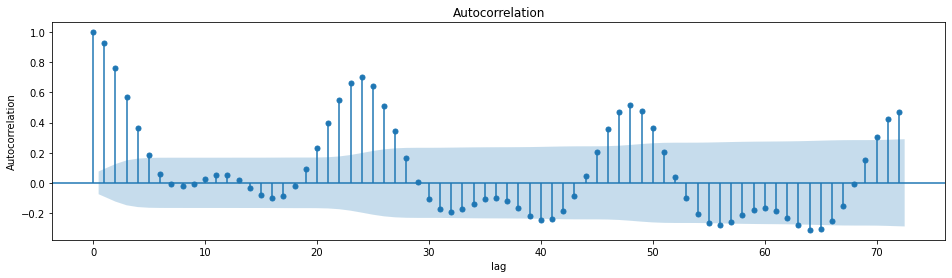

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data_v1.drop(["exog"], axis=1).dropna(), alpha=.05, lags=72)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

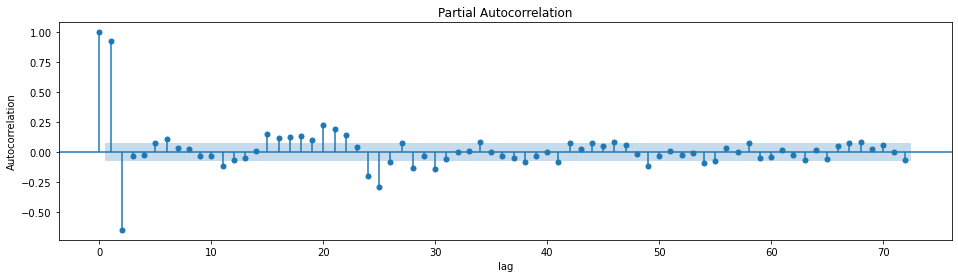

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_v1.drop(["exog"], axis=1).dropna(), alpha=0.05, lags=72, method='ols')
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

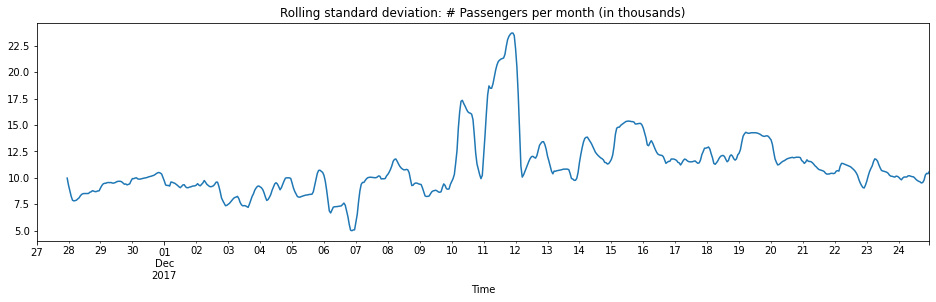

In [27]:
(data_v1.dropna().price).rolling(24).std().plot();
plt.xlabel('Time')
plt.title('Rolling standard deviation: # Passengers per month (in thousands)')
plt.show()

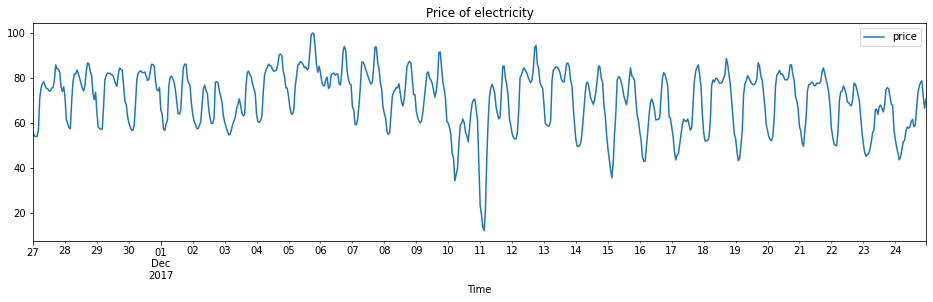

In [20]:
plot_data(data_v1.dropna(), "price")

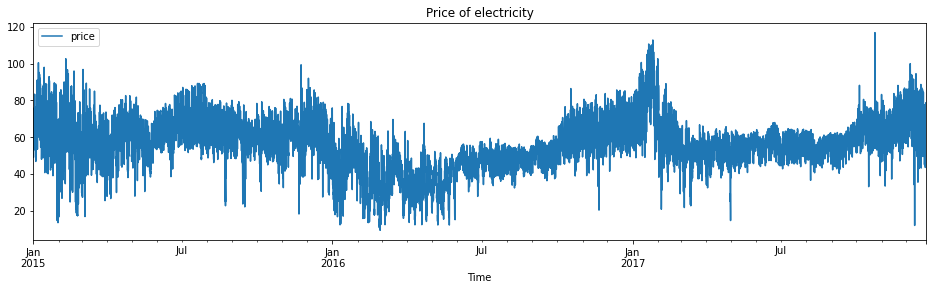

In [16]:
plot_data(data_v2.dropna(), "price")

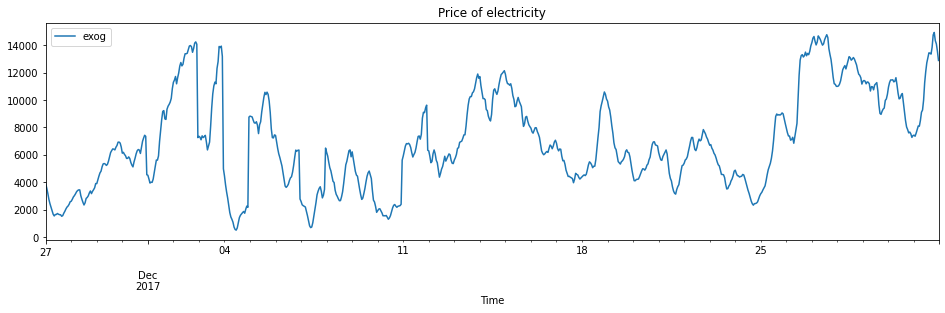

In [10]:
plot_data(data_v1, "exog")

In [11]:
#check data for nan
data_v2.isnull().sum()

price    168
exog       0
dtype: int64

In [12]:
#check that there are no missing hours
data_v2 = data_v2.resample('H').asfreq()
data_v2.isnull().sum()

price    168
exog       0
dtype: int64

In [22]:
data_2015 = slice_dates(data_v2, "2015-01-01", "2015-12-31")
data_2016 = slice_dates(data_v2, "2016-01-01", "2016-12-31")
data_2017 = slice_dates(data_v2, "2017-01-01", "2017-12-31")



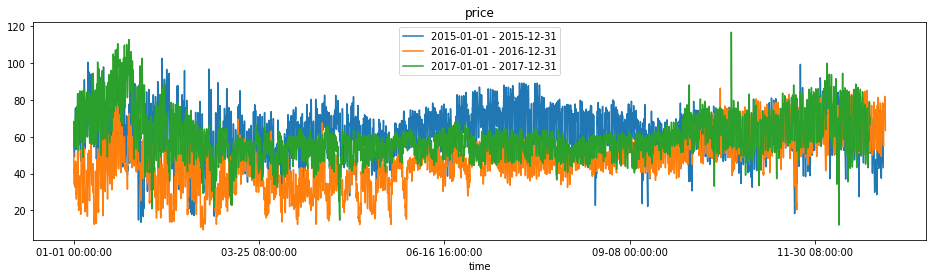

In [13]:
plot_multiple_datasets([data_2015, data_2016, data_2017], "price")

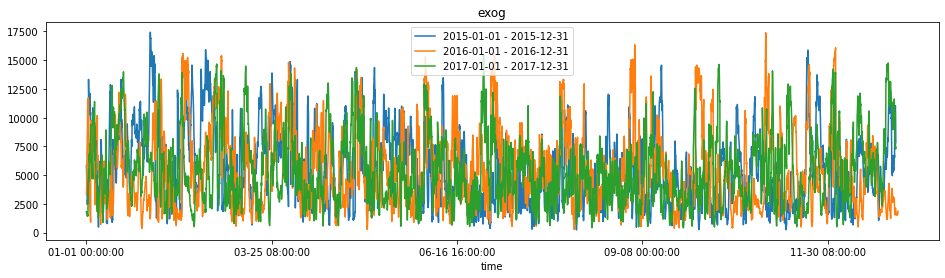

In [14]:
plot_multiple_datasets([data_2015, data_2016, data_2017], "exog")

In [23]:
data_2015.index = data_2015.index.strftime('%m-%d %H:%M:%S')
data_2016.index = data_2016.index.strftime('%m-%d %H:%M:%S')
data_2017.index = data_2017.index.strftime('%m-%d %H:%M:%S')



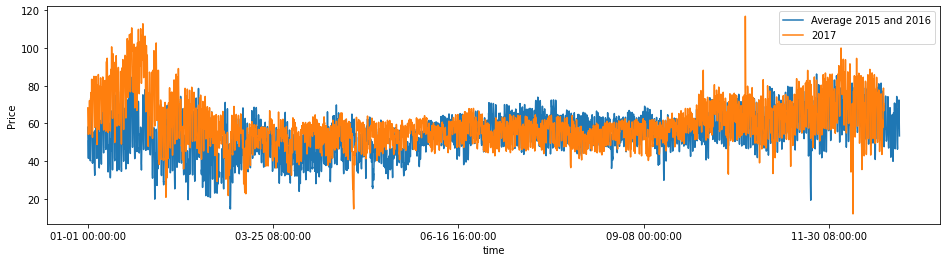

In [28]:
((data_2015+data_2016)/2).price.plot(label = "Average 2015 and 2016")
data_2017.price.plot(label = "2017")
plt.ylabel("Price")
plt.legend()

In [17]:
prediction, actual, mae = predict_from_past(data_v2, beginning_date = data_v1.index[-168*2], end_date = data_v1.index[-169])
mae

6.387857142857142

In [22]:
data = data_v2.copy()
mean_previous_years = (data[(data.index>=f"2015-12-25")&(data.index<f"2016-01-01")].reset_index()["price"]+data[(data.index>=f"2016-12-25")&(data.index<f"2017-01-01")].reset_index()["price"])/2


In [25]:
submission = pd.DataFrame(data=mean_previous_years, columns=["price"])
submission.to_csv("mean_previous_years", index=False)

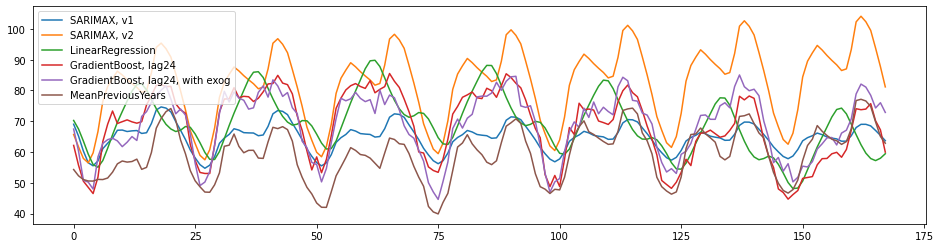

In [29]:
plt.plot(pd.read_csv("sarimax_no_exogenus_v1"), label="SARIMAX, v1") ##15
plt.plot(pd.read_csv("sarimax_no_exogenus_v2"), label="SARIMAX, v2") ##33
plt.plot(pd.read_csv("linear_regression_submission3"), label="LinearRegression") ##20 
plt.plot(pd.read_csv("gradient_boost_submission4"), label="GradientBoost, lag24") ##19
plt.plot(pd.read_csv("gradient_boost_with_exog_lag24"), label="GradientBoost, lag24, with exog") ##19

plt.plot(pd.read_csv("mean_previous_years"), label="MeanPreviousYears") ##11.85

plt.legend()